# Abstract

# Introduction

# `Analysis`

## Imports

In [1]:
import numpy as np

In [2]:
import pandas as pd

In [3]:
from scipy import stats as stats

In [4]:
import matplotlib.pyplot as plt

In [5]:
import seaborn as sns

In [6]:
import statsmodels.api as sm

In [7]:
import statsmodels.formula.api as smf

In [8]:
data = pd.read_csv('ccs2022.csv')

## Helper functions

In [9]:
def outlierFunc(x):
    q1 = np.quantile(x, 0.25) # Lower quartile
    q3 = np.quantile(x, 0.75) # Upper quartile
    
    iqr = q3-q1 # Interquartile range
    
    iqr_bounds = [q1 - (1.5 * iqr), q3 + (1.5 * iqr)] # Bounds
    
    outliers = x[(x <= iqr_bounds[0]) | (x >= iqr_bounds[1])] # Selecting data beyond bounds
    
    return outliers

PRINT_ENABLE = False 
print_ = lambda *args, **kwargs: print(*args, **kwargs) if PRINT_ENABLE else ''

## Behavioral Analysis

#### First looks at data

In [10]:
data.sample(5); # Random sample of 5

In [11]:
list(data.columns);

#### Data preprocessing

In [12]:
# Checking for empty values
data.isna().any();

In [13]:
# Adding columns for a global trial counter and participant accuracy 
data.rename(columns={'Unnamed: 0':'global_trial'}, inplace=True)
data['correct'] = (data['J_pressed'] == (data['yj'] > data['yf'])).map(int)

#### Outliers

The most important columns for analysis are participant accuracy and reaction time as these reflect performance in the experiment.

In [14]:
per_correct = data['correct'].mean() # Average accuracy
par_correct = data.groupby('participant_id').correct.mean() # Participant accuracy
par_RT = data.groupby('participant_id').decision_time.mean() # Reaction time

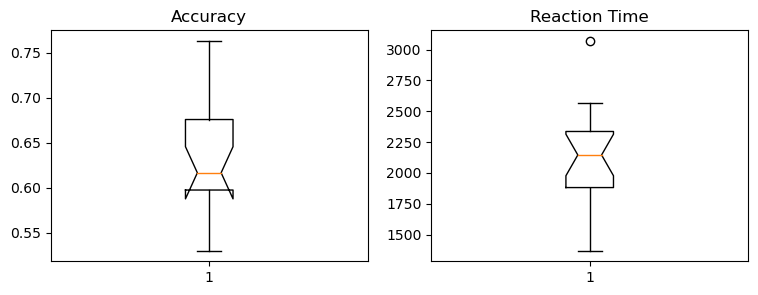

In [56]:
print_("Average accuracy:", per_correct, "\n")
print_(par_correct.to_frame(), "\n")
print_(par_RT.to_frame(), "\n")

plt.figure(figsize=(9, 3))
plt.subplot(1,2,1).boxplot(par_correct, notch=True)
plt.title("Accuracy")
plt.subplot(1,2,2)
plt.boxplot(par_RT, notch=True)
plt.title("Reaction Time")
plt.show()

In [16]:
outlierFunc(par_correct);

In [19]:
outlierFunc(par_RT);

After taking a look at the accuracy data we found one outlier performing well above others. We identify this as participant number 18. We also note two outliers in reaction time data, with participants 18 and 11 having exceptionally fast and slow reaction times, respectively.

#### Excluding outliers

We decided to exclude only participant 18 due to having both higher accuracy and lower RT than all other participants. However, we keep participant 11 in the data as despite their slow reaction times their performance was not exceptional.

In [20]:
data = data[data['participant_id'] != 18] # Excluding participant 18
# Computing new means after exclusion
per_correct = data['correct'].mean()
par_correct = data.groupby('participant_id').correct.mean()
par_RT = data.groupby('participant_id').decision_time.mean()

#### Do participants perform better than chance?

In [21]:
print_("Average accuracy:", per_correct, "\n")
t_par, p_par = stats.ttest_1samp(par_correct, 0.5)
print_("t =", t_par, "p =", p_par)

''

A one-sample t-test against a 50% chance level (participants had two alternatives) reveals that participants performed statistically significantly above chance level (t = 9.75, p < 0.05) with an average accuracy of 63.3%. 

#### Do they improve over trials within each round?

In [22]:
trial_correct = data.groupby('trial').correct.mean()
trial_correct;

In [23]:
trial_mod = smf.ols(formula="correct ~ trial", data=data).fit()
trial_mod.summary();

A linear regression analysis indicated that participants performed better trial-wise within blocks ($\beta$ = 0.014, $R^2$ = 0.007, p < 0.001), performing on average 1.4% better each trial after the first.

#### Do they improve over rounds?

In [24]:
task_correct = data.groupby(['task', 'slow']).correct.mean()
task_correct;

In [25]:
task_mod = smf.ols(formula="correct ~ task", data=data).fit()
task_mod.summary();

We also performed a linear regression analysis to test whether participants performed better at the start of the experiment but found no statistically significant influence of task (p = 0.242). 

#### How does the number of observed features affect performance?

In [26]:
feat_correct = data.groupby('num_features').correct.mean()
feat_correct;

In [27]:
feat_mod = smf.ols(formula="correct ~ num_features", data=data).fit()
feat_mod.summary();

We found that the number of features has a statistically significant influence on participant accuracy ($\beta$ = -0.043, $R^2$ = 0.005, p < 0.001), with the addition of each feature decreasing accuracy on average by 4.3%.

#### How does time pressure affect performance?

In [28]:
slow_correct = data.groupby('slow').correct.mean()
slow_correct;

In [29]:
t_slow, p_slow = stats.ttest_rel(data[data['slow'] == 0].correct, data[data['slow'] == 1].correct)
print_("t =", t_slow, "p =", p_slow)

''

Participants also had better accuracy in slow trials over regular trials as indicated by an independent samples t-test (df = 17, t = -3.5, p < 0.001), performing on average 4.5% better in slow trials.

#### RT Correlation

In [30]:
data.groupby('participant_id')[['decision_time', 'correct']].mean();

In [31]:
stats.pearsonr(par_correct, par_RT);

In [32]:
RT_mod = smf.ols(formula="correct ~ decision_time", data=data).fit()
RT_mod.summary();

We found a significant negative relationship between accuracy and decision time (

#### Bigression

In [33]:
big_mod = smf.ols(formula="correct ~ num_features * C(slow) * decision_time", data=data).fit()
big_mod.summary();

## Parameter Fitting

`Look at the resulting parameters and try to answer the following questions`

### Recorla-Wagner

> • Does time pressure lead to slower learning?

> • Does time pressure lead to more noisy decisions?

### Kalman Filter

> • Does time pressure lead to slower learning?

> • Does time pressure lead to more noisy decisions?

### Error Model

> • Does time pressure lead to slower learning?

> • Does time pressure lead to more noisy decisions?

### <.....> Model

> • Does time pressure lead to slower learning?

> • Does time pressure lead to more noisy decisions?

#### Random policy

In [34]:
N = len(pd.unique(data['participant_id']))

In [35]:
RP_BIC = np.full(N, 0 - 2 * 300 * np.log(0.5))
RP_BIC

array([415.88830834, 415.88830834, 415.88830834, 415.88830834,
       415.88830834, 415.88830834, 415.88830834, 415.88830834,
       415.88830834, 415.88830834, 415.88830834, 415.88830834,
       415.88830834, 415.88830834, 415.88830834, 415.88830834,
       415.88830834, 415.88830834])

## Model Comparison

> •  Which model explains the human data best?

In [36]:
RW_BIC = np.random.rand(N) * 1000
KF_BIC = np.random.rand(N) * 1000

In [37]:
all_BIC = np.array([RW_BIC, KF_BIC, RP_BIC])

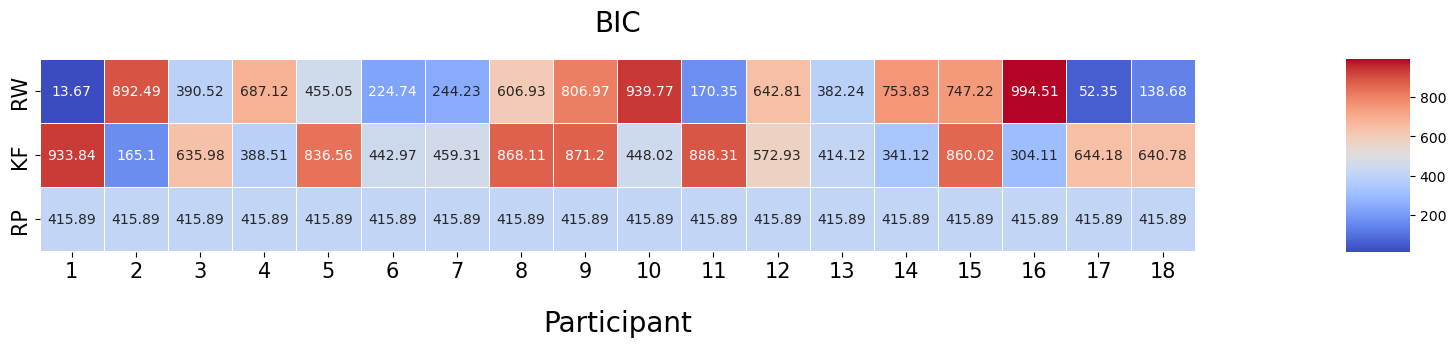

In [38]:
all_BICr = [np.around(num,2) for num in all_BIC]

f, (ax, cbar_ax) = plt.subplots(1,2, gridspec_kw = {'width_ratios': [0.95, 0.05]}, figsize = (18,2))
f.set_figheight(2.5)

sns.heatmap(all_BICr, cmap = 'coolwarm', linewidths = 0.5, square = True, annot = True, fmt = 'g',
            ax = ax, cbar_ax = cbar_ax)

ax.set_xticklabels(np.arange(N) + 1, fontsize = 15);
ax.set_yticklabels(['RW', 'KF', 'RP'], fontsize = 15);
ax.set_xlabel('Participant', labelpad = 20, fontsize = 20);
ax.set_title('BIC', pad = 20, fontsize = 20);

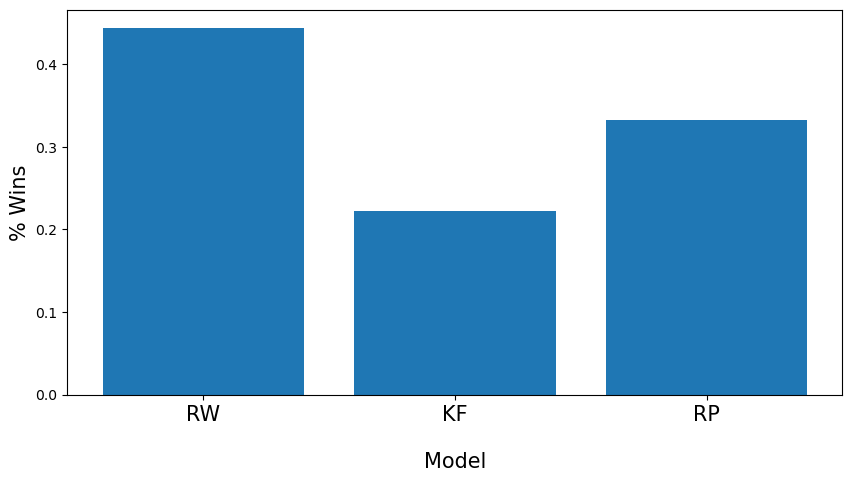

In [39]:
model_wins = np.argmin(all_BIC, 0)
model_plot = np.histogram(model_wins, [0, 1, 2, 3])[0] / N

plt.figure(figsize=(10,5))

plt.bar(['RW','KF','RP'], model_plot);
plt.xticks(fontsize = 15);
plt.xlabel('Model', labelpad = 20, fontsize = 15);
plt.ylabel('% Wins', fontsize=15);

> • Does time pressure lead to simpler learning strategies?

# Methods

# Results

# Discussion

# References